Best Parameters: {'regressor__colsample_bytree': 0.8, 'regressor__gamma': 5, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 300, 'regressor__subsample': 0.8}
Best Score (MSE): 2.0807245277759163
Mean Squared Error: 2.1022297104674026
Mean Absolute Error: 0.8792694359068658
R² Score: 0.5984481251874477


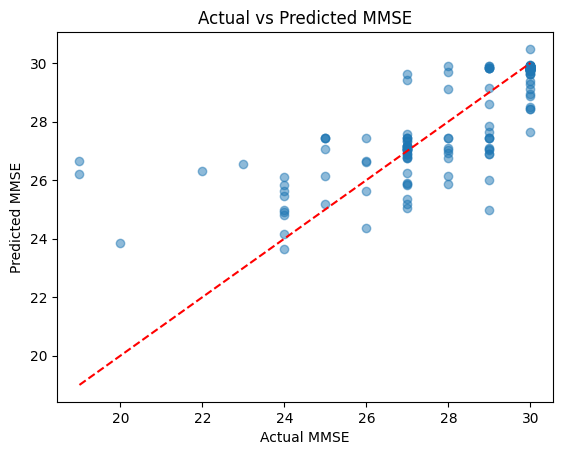

In [2]:
import os
import re
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Helper function to extract data from text files
def load_data(file_pattern, base_path):
    data = []
    record_ids = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids

# Helper function to load labels
def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df.set_index('Record-ID')[['Age', 'Class', 'Converted-MMSE']]  # Removed 'Gender'

# Load and combine data for CTD, PFT, and SFT
base_path = "../process/PROCESS-V1/"
file_patterns = {
    'CTD': r"Process-rec-\d+__CTD\.txt",
    'PFT': r"Process-rec-\d+__PFT\.txt",
    'SFT': r"Process-rec-\d+__SFT\.txt"
}
data_dict = {}
record_ids_dict = {}

for key, pattern in file_patterns.items():
    data, record_ids = load_data(pattern, base_path)
    data_dict[key] = data
    record_ids_dict[key] = record_ids

label_file = "../process/PROCESS-V1/dem-info-filled-mmse-score.csv"
labels = load_labels(label_file)

# Combine CTD, PFT, and SFT data
combined_data = []
for record_id in labels.index:
    if all(record_id in record_ids_dict[key] for key in file_patterns):
        ctd_text = data_dict['CTD'][record_ids_dict['CTD'].index(record_id)]
        pft_text = data_dict['PFT'][record_ids_dict['PFT'].index(record_id)]
        sft_text = data_dict['SFT'][record_ids_dict['SFT'].index(record_id)]
        row = labels.loc[record_id]
        combined_data.append({
            'Record-ID': record_id,
            'CTD_Text': ctd_text,
            'PFT_Text': pft_text,
            'SFT_Text': sft_text,
            'Age': row['Age'],
            'Class': row['Class'],
            'Converted-MMSE': row['Converted-MMSE'],
        })

# Create DataFrame
df = pd.DataFrame(combined_data)

df.dropna(inplace=True)

# Combine all text for text feature extraction
df['Combined_Text'] = df['CTD_Text'] + ' ' + df['PFT_Text'] + ' ' + df['SFT_Text']

# Map 'Class' to numerical values
class_mapping = {'MCI': 1, 'Dementia': 2, 'HC': 0}
df['Class_Numeric'] = df['Class'].map(class_mapping)

# Prepare features and labels
X_combined_text = df['Combined_Text']
X_numeric = df[['Age', 'Class_Numeric']]
y = df['Converted-MMSE']

# Extract text features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_text_features = tfidf_vectorizer.fit_transform(X_combined_text)

# Combine all features
X_combined = pd.concat([
    pd.DataFrame(X_text_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out()),
    X_numeric.reset_index(drop=True)
], axis=1)

# Update and fit pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', MinMaxScaler(), X_numeric.columns.tolist()),
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# Perform grid search
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__gamma': [0, 1, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_combined, y)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)

# Cross-validated predictions
y_pred = cross_val_predict(grid_search.best_estimator_, X_combined, y, cv=5)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Plot predictions vs actual values
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel('Actual MMSE')
plt.ylabel('Predicted MMSE')
plt.title('Actual vs Predicted MMSE')
plt.show()
